Mounted at /content/drive
Found 1075 images belonging to 4 classes.
Found 79 images belonging to 4 classes.
Found 74 images belonging to 4 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


34/34 ━━━━━━━━━━━━━━━━━━━━ 855s 24s/step - accuracy: 0.4967 - loss: 7.8411 - val_accuracy: 0.5063 - val_loss: 7.7338
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 758s 22s/step - accuracy: 0.7287 - loss: 6.6743 - val_accuracy: 0.5063 - val_loss: 6.8792
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 804s 22s/step - accuracy: 0.7314 - loss: 5.9051 - val_accuracy: 0.5063 - val_loss: 6.2087
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 740s 22s/step - accuracy: 0.7241 - loss: 5.2454 - val_accuracy: 0.5063 - val_loss: 5.5934
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 778s 23s/step - accuracy: 0.7207 - loss: 4.6805 - val_accuracy: 0.5063 - val_loss: 5.1555
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 772s 23s/step - accuracy: 0.7295 - loss: 4.1655 - val_accuracy: 0.5063 - val_loss: 4.6715
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 741s 22s/step - accuracy: 0.7344 - loss: 3.7083 - val_accuracy: 0.5063 - val_loss: 4.2683
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 774s 23s/step - accuracy: 0.7486 - loss: 3.3293 - val_accuracy: 0.5063 - val_

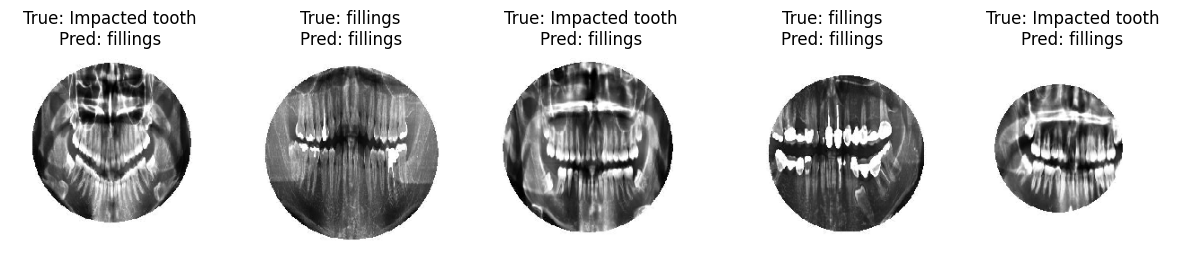

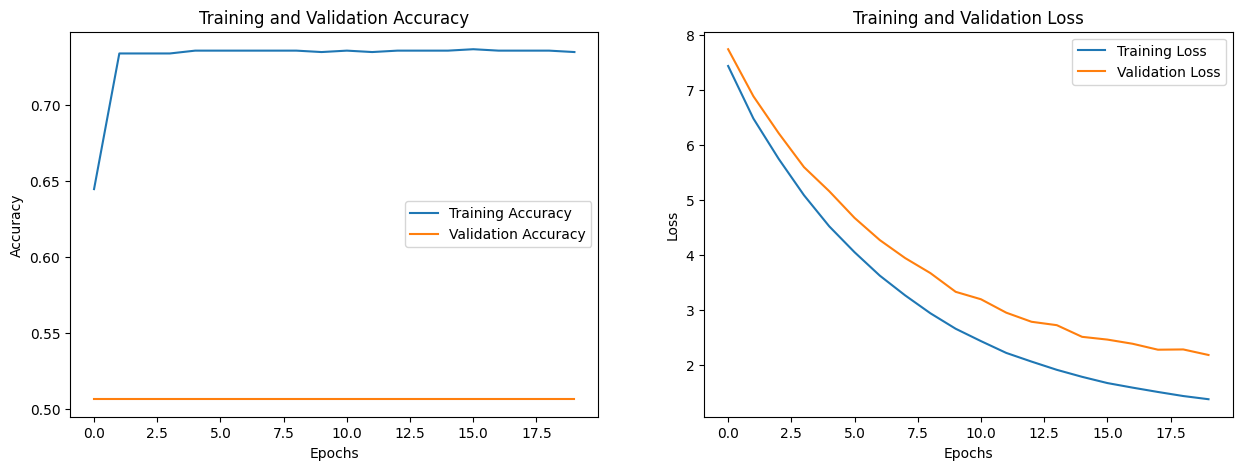

In [ ]:
#VGG16 model
import os
import tensorflow as tf
from google.colab import drive
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import numpy as np

# Mount Google Drive
drive.mount("/content/drive")

# Path to your dataset (update this to your own dataset location)
base_dir = '/content/drive/My Drive/final project'  # Adjust path to where your dataset is located

# Directory structure for image dataset
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

# VGG16 Model:

def create_vgg16_model(input_shape, num_classes):
    # Load VGG16 model pre-trained on ImageNet without the top classification layers
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the base layers
    for layer in base_model.layers:
        layer.trainable = False  # Freeze all layers

    # Add custom layers on top
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # Dense layer with L2 regularization
    x = Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = Dropout(0.5)(x)  # Dropout to prevent overfitting

    # Final output layer with softmax activation
    predictions = Dense(num_classes, activation='softmax')(x)

    # Create final model
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Image Preprocessing with ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,               # Normalize image pixel values to [0, 1]
    rotation_range=40,            # Randomly rotate images
    width_shift_range=0.2,        # Randomly shift images horizontally
    height_shift_range=0.2,       # Randomly shift images vertically
    shear_range=0.2,              # Apply shear transformations
    zoom_range=0.2,               # Random zoom
    horizontal_flip=True,         # Randomly flip images horizontally
    fill_mode='nearest'           # Fill in missing pixels after transformations
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load data using ImageDataGenerator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Resize images to 224x224 (required for VGG16)
    batch_size=32,
    class_mode='categorical'  # Multi-class classification
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Create the VGG16 model
input_shape = (224, 224, 3)  # Standard input shape for VGG16
num_classes = len(train_generator.class_indices)  # Number of classes (based on the train dataset)

model = create_vgg16_model(input_shape, num_classes)

# Compile the model with gradient clipping
optimizer = Adam(learning_rate=0.0001)  # Low learning rate to prevent overfitting
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks: Early stopping and ModelCheckpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_vgg16_model.keras', save_best_only=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=20,  # Increased to 20 epochs for better performance
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint]
)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_acc}')

# Optional: Save the final model
model.save('final_vgg16_model.keras')  # Saving the final model as .keras file format

# Visualize Predictions and Real Images
def visualize_predictions(model, test_generator, num_images=5):
    # Get a batch of images from the test set
    images, labels = next(test_generator)

    # Make predictions
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(labels, axis=1)

    # Get the class names from the generator's class_indices attribute
    class_names = list(test_generator.class_indices.keys())

    # Plot the images with their true and predicted labels
    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        ax = plt.subplot(1, num_images, i+1)
        ax.imshow(images[i])  # Display the image
        ax.set_title(f"True: {class_names[true_labels[i]]}\nPred: {class_names[predicted_labels[i]]}")
        ax.axis('off')
    plt.show()

# Plot Training History
def plot_training_history(history):
    # Plot Training & Validation Accuracy and Loss
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Accuracy plot
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Training and Validation Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    # Loss plot
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Training and Validation Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.show()

# Visualize predictions
visualize_predictions(model, test_generator)

# Plot training history
plot_training_history(history)


In [ ]:
"""In conclusion :
ResNet’s 94% accuracy demonstrates its ability to effectively learn complex patterns within the dataset, outperforming VGG16 due to
its advanced architecture and fine-tuning. While the result is promising, further evaluation on test data and class-wise metrics is essential to confirm its
generalization and ensure the performance is not influenced by overfitting or data imbalance."""